## Load the training data into feature matrix, class labels, and event ids:

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from expansion import *
%load_ext autoreload
%autoreload 2
import pandas as pd
from IPython.display import display
from proj1_helpers import *

In [2]:
pri0_to_drop = ["DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_lep_eta_centrality","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi"]
pri1_to_drop = ["DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_lep_eta_centrality","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi"]

In [3]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
hb = pd.read_csv(DATA_TRAIN_PATH, sep=',')
pd.options.display.max_columns = None

hb = hb.drop(['Id'], 1)
#hb.describe()

In [4]:
def cleanDataSet(dataset):
    dataset = dataset.replace(-999, np.nan)
    pri0 = dataset[dataset.PRI_jet_num==0].copy()
    pri0 = pri0.drop(pri0_to_drop,1)
    pri0 = pri0.drop(["PRI_jet_num","PRI_jet_all_pt"],1)

    pri1 = dataset[dataset.PRI_jet_num == 1].copy()
    pri1 = pri1.drop(pri1_to_drop,1)
    pri1 = pri1.drop(["PRI_jet_num"],1)

    pri2 = dataset[dataset.PRI_jet_num == 2].copy()
    pri2 = pri2.drop(["PRI_jet_num"],1)

    pri3 = dataset[dataset.PRI_jet_num == 3].copy()
    pri3 = pri3.drop(["PRI_jet_num"],1)
    
    return [pri0,pri1,pri2,pri3]

In [5]:
def extractPredictions(dataset):
    return dataset.Prediction.apply(lambda x: -1 if x == 'b' else 1)

In [6]:
def normalizeDataset(dataset):
    dataset = (dataset - dataset.mean()) / dataset.std()
    dataset = dataset.fillna(0)
    dataset = (dataset - dataset.mean()) / dataset.std()
    return dataset

In [7]:
def normalizeDataset_numpy(dataset):
    dataset = (dataset - dataset.mean(axis=0)) / dataset.std(axis=0)
    dataset = np.nan_to_num(dataset)
    dataset = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)
    return dataset

In [8]:
def tildaNumpy(X):
    return np.c_[np.ones(X.shape[0]), X]

In [9]:
POLYNOMIAL_EXPANSION_DEGREE = 12

pri = cleanDataSet(hb)
predictions = []
pri_cross_validation_test = []
prediction_cross_validation_test = []

In [20]:
'''REMOVE SKLEAR FOR CROSS VALIDATION'''
from sklearn.model_selection import train_test_split


for idx, dataset in enumerate(pri):
    predictions.append(extractPredictions(dataset))
    dataset = dataset.drop(['Prediction'],1)
    pri[idx] = tildaNumpy(normalizeDataset_numpy(polynomial_expansion( normalizeDataset(dataset).to_numpy(), POLYNOMIAL_EXPANSION_DEGREE)))
    X_train, X_test, y_train, y_test = train_test_split(pri[idx],predictions[idx],test_size=0.1, random_state=0)
    pri[idx] = X_train
    predictions[idx] = y_train
    pri_cross_validation_test.append(X_test)
    prediction_cross_validation_test.append(y_test)
    # pri[idx] is our tX depending on jet_num

In [22]:
def score(X, w, y):
    return (y == predict_labels(w,X)).sum()/len(y)

## Do your thing crazy machine learning thing here :) ...

In [53]:
def compute_e(y, tx, w):
    return y - tx @ w

def compute_loss_MSE(n2, e):
    return (e.T @ e) / n2
    
def compute_gradient_MSE(tx, n, e):
    return - tx.T @ e / n

def compute_loss_MAE(n, e):
    return 1/n * np.sum(np.abs(e))
    
def compute_gradient_MAE(tx, n, e):
    return -1/n*tx.T @ np.sign(e)

def compute_loss_rmse(n2, e):
    return np.sqrt(2 * compute_loss_MSE(n2, e))

In [37]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """
    Linear regression using gradient descent.
    Uses MSE.
    
    Parameters
    ----------
    y:  ndarray
        the labels
    tx: ndarray
        vector x tilde, i.e. the parameters with a bias term
    initial_w: ndarray
        initial weight vector
    max_iters: int
        maximum number of iterations
    gamma: float
        learning rate

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """
    
    
    
    loss = 0
    w = initial_w
    n = y.shape[0]
    n2 = n*2
    
    for n_iter in range(max_iters):
        e = compute_e(y, tx, w)
        gradient = compute_gradient_MSE(tx, n, e)
        loss = compute_loss_MSE(n2, e)
        
        # Update weights
        w -= gamma * gradient
        #print("Gradient Descent({bi}/{ti}): loss={l}, w={w}".format(
        #      bi=n_iter, ti=max_iters - 1, l=loss, w=w[0]))

    return w, loss

In [40]:
'''
weights = np.array([])
for i in range(100):
    initial_w = np.full(tX.shape[1], i/100)
    max_iters = 100
    gamma = 0.3
    w, loss = least_squares_GD(y, tX, initial_w, max_iters, gamma)
    weights = np.append(weights, loss)
idx = np.argmin(weights)
'''
initial_w = np.zeros(pri[0].shape[1])
max_iters = 1000
gamma = 0.3
w, loss = least_squares_GD(predictions[0], pri[0], initial_w, max_iters, gamma)
print(loss)

/home/bastien/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in matmul
  


nan


In [44]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """
    Linear regression using gradient descent.
    Uses MAE.
    
    Parameters
    ----------
    y:  ndarray
        the labels
    tx: ndarray
        vector x tilde, i.e. the parameters with a bias term
    initial_w: ndarray
        initial weight vector
    max_iters: int
        maximum number of iterations
    gamma: float
        learning rate

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """
    
    loss = 0
    w = initial_w
    n = y.shape[0]
    n2 = n*2
    
    for n_iter in range(max_iters):
        e = compute_e(y, tx, w)
        gradient = compute_gradient_MAE(tx, n, e)
        loss = compute_loss_MAE(n2, e)
        
        # Update weights
        w -= gamma * gradient
        #print("Gradient Descent({bi}/{ti}): loss={l}, w={w}".format(
        #      bi=n_iter, ti=max_iters - 1, l=loss, w=w[0]))

    return w, loss

In [47]:
initial_w = np.zeros(pri[0].shape[1])
max_iters = 1000
gamma = 0.3
w, loss = least_squares_GD(predictions[0], pri[0], initial_w, max_iters, gamma)
print(loss)

0.4465032089414749


In [48]:
def least_squares_SGD(y, tx, initial_w, max_iters, gamma):
    """
    Linear regression using stochastic gradient descent.
    Uses MSE.
    
    Parameters
    ----------
    y:  ndarray
        the labels
    tx: ndarray
        vector x tilde, i.e. the parameters with a bias term
    initial_w: ndarray
        initial weight vector
    max_iters: int
        maximum number of iterations
    gamma: float
        learning rate

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """
    
    loss = 0
    w = initial_w[:, np.newaxis]
    n = y.shape[0]
    n2 = n*2
    data_size = len(y)
    shuffled_indices = np.random.permutation(np.arange(data_size))
    shuffled_y = y[shuffled_indices]
    shuffled_tx = tx[shuffled_indices]
    shuffled_y = shuffled_y[:,np.newaxis]
    for n_iter, by, btx in zip(range(max_iters), shuffled_y, shuffled_tx):
        by = by[np.newaxis]
        btx = btx[np.newaxis, :]
        e = compute_e(by, btx, w)
        gradient = compute_gradient_MSE(btx, n, e)
        loss = compute_loss_MSE(n2, e)
        
        # Update weights
        w -= gamma * gradient
        #print("Gradient Descent({bi}/{ti}): loss={l}, w={w}".format(
        #      bi=n_iter, ti=max_iters - 1, l=loss, w=w[0]))
    return w, compute_loss_MSE(n2, compute_e(y, tx, w[:,0]))

In [49]:
initial_w = np.full(pri[0].shape[1], 0.1)
max_iters = 100000
gamma = 0.7
w, loss = least_squares_SGD(predictions[0], pri[0], initial_w, max_iters, gamma)
print(loss)

/home/bastien/Anaconda3/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


nan


In [50]:
def least_squares(y, tx):
    """
    Linear regression using normal equations.
    Use MSE loss function
    
    Parameters
    ----------
    y:  ndarray
        the labels
    tx: ndarray
        vector x tilde, i.e. the parameters with a bias term

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """    
    
    w = la.solve(tx.T @ tx, tx.T @ y)
    
    return w, compute_loss_MSE(y.shape[0]*2, compute_e(y, tx, w))

In [52]:
w, loss = least_squares(predictions[0], pri[0])
print(loss)

76.15658150782815


# Ridge regression
with cross-validation

In [118]:
def ridge_regression(y, tx, lambda_):
    """
    Ridge regression using normal equations.
    
    Parameters
    ----------
    y : ndarray
        Description of y
    ...

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """ 
     
    X = tx.T @ tx
    n = y.shape[0]
    w = la.solve(X + lambda_ * (2 * n) * np.eye(X.shape[0]), tx.T @ y)
    return w, compute_loss_rmse(2 * n, compute_e(y, tx, w))



In [96]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # split the data based on the given ratio
    # ***************************************************
    N = x.shape[0]
    indices_training = np.random.choice(N, (int)(ratio*N),replace=False)
    mask_training = np.zeros(N, dtype=bool)
    mask_training[indices_training] = True
    mask_testing = ~mask_training
    return (x[mask_training], x[mask_testing], y[mask_training], y[mask_testing])

In [97]:
from plots import *
def ridge_regression_cross(x, y, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-3, 0, 30)
    # ***************************************************
    # split the data, and return train and test data
    # ***************************************************
    x_train, x_test, y_train, y_test = split_data(x,y, ratio, seed)
    
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # ridge regression with a given lambda
        # ***************************************************
        weights, rmse = ridge_regression(y_train, x_train, lambda_)
        rmse_tr.append(rmse)
        rmse_te.append(compute_loss_rmse(y_test.shape[0]*2, compute_e(y_test,x_test, weights)))

        print("proportion={p}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas)
        

proportion=0.8, lambda=0.001, Training RMSE=0.695, Testing RMSE=1.151
proportion=0.8, lambda=0.001, Training RMSE=0.695, Testing RMSE=0.977
proportion=0.8, lambda=0.002, Training RMSE=0.696, Testing RMSE=0.834
proportion=0.8, lambda=0.002, Training RMSE=0.696, Testing RMSE=0.737
proportion=0.8, lambda=0.003, Training RMSE=0.697, Testing RMSE=0.696
proportion=0.8, lambda=0.003, Training RMSE=0.697, Testing RMSE=0.703
proportion=0.8, lambda=0.004, Training RMSE=0.698, Testing RMSE=0.741
proportion=0.8, lambda=0.005, Training RMSE=0.699, Testing RMSE=0.792
proportion=0.8, lambda=0.007, Training RMSE=0.699, Testing RMSE=0.842
proportion=0.8, lambda=0.009, Training RMSE=0.700, Testing RMSE=0.882
proportion=0.8, lambda=0.011, Training RMSE=0.701, Testing RMSE=0.910
proportion=0.8, lambda=0.014, Training RMSE=0.702, Testing RMSE=0.923
proportion=0.8, lambda=0.017, Training RMSE=0.704, Testing RMSE=0.922
proportion=0.8, lambda=0.022, Training RMSE=0.705, Testing RMSE=0.909
proportion=0.8, lamb

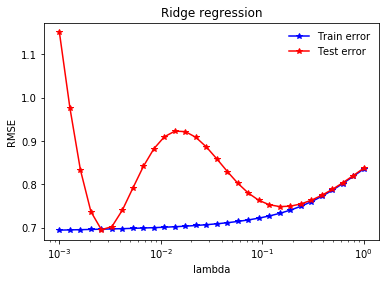

In [73]:
ridge_regression_cross(pri[0], predictions[0], 0.8, 0)

In [119]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [127]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""

    x_tr = np.delete(x, k_indices[k], axis=0)
    y_tr = np.delete(y, k_indices[k], axis=0)
    
    x_te = x[k_indices[k]]
    y_te = y[k_indices[k]]
    w, rmse = ridge_regression(y_tr, x_tr, lambda_)
    
    n = y.shape[0]
    loss_tr = np.sqrt(rmse)
    loss_te = np.sqrt(2 * compute_loss_MSE(2*n , compute_e(y_te, x_te, w)))
    return loss_tr, loss_te

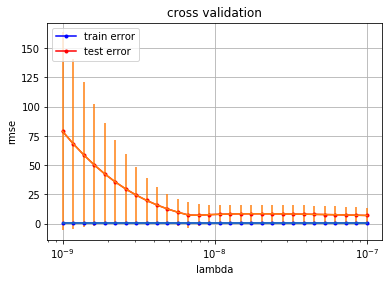

In [130]:
def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-9, -7, 30)
    
    y = predictions[0]
    y = y[:,np.newaxis]
    x = pri[0]
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    var_tr = []
    var_te = []
    
    for lambda_ in lambdas:
        loss_tr = []
        loss_te = []
        for k in range(k_fold):
            tr, te = cross_validation(y, x, k_indices, k, lambda_, degree)
            loss_tr.append(tr)
            loss_te.append(te)
        rmse_tr.append(np.mean(loss_tr))
        rmse_te.append(np.mean(loss_te))
        var_tr.append(np.std(loss_tr))
        var_te.append(np.std(loss_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te, var_tr, var_te)

cross_validation_demo()

# Logistic regression

In [62]:
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1/(1 + np.exp(-t))
    
def compute_loss_logistic(y, tx, w):
    """compute the cost by negative log likelihood."""
    return np.sum(np.log(1 + np.exp(tx @ w)) - y * (tx @ w))


def compute_gradient_logistic(y, tx, w):
    """compute the gradient of loss."""
    return tx.T @ (sigmoid(tx @ w) - y)


def logistic_regression_step(y, tx, w):
    """return the loss, gradient"""
    return compute_loss_logistic(y, tx, w), compute_gradient_logistic(y, tx, w)
  

In [63]:
# TODO
def logistic_regression(y, tx, lambda_):
    """
    Logistic regression using gradient descent or SGD.
    
    Parameters
    ----------
    y : ndarray
        Description of y
    ...

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """  
    def learning_by_gradient_descent(y, tx, w, gamma):
        """
        Do one step of gradient descen using logistic regression.
        Return the loss and the updated w.
        """
        loss, gradient = logistic_regression_step(y, tx, w)
        w = w - gamma * gradient
        return loss, w
    
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    #gamma = 0.01
    losses = []

    # build tx
    w = np.zeros((tx.shape[1], 1))
    y = y[:,np.newaxis]

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
     
    print("loss={l}".format(l=compute_loss_logistic(y, tx, w)))
    return w, losses[-1]
    

In [64]:
lambda_ = 1e-8
w, loss = logistic_regression(predictions[0], pri[0], lambda_)

Current iteration=0, loss=62328.487623130844
Current iteration=100, loss=48973.81914445322
Current iteration=200, loss=37338.256705392734
Current iteration=300, loss=26872.57981274616
Current iteration=400, loss=17245.077432882572
Current iteration=500, loss=8249.602539250398
Current iteration=600, loss=-248.31740935856556
Current iteration=700, loss=-8340.885215389557
Current iteration=800, loss=-16094.27607548367
Current iteration=900, loss=-23557.94346503339
Current iteration=1000, loss=-30770.171562482265
Current iteration=1100, loss=-37761.51356869888
Current iteration=1200, loss=-44556.990240726744
Current iteration=1300, loss=-51177.53529141257
Current iteration=1400, loss=-57640.970011219055
Current iteration=1500, loss=-63962.67691413828
Current iteration=1600, loss=-70156.07743936771
Current iteration=1700, loss=-76232.98001459955
Current iteration=1800, loss=-82203.84092925806
Current iteration=1900, loss=-88077.9654617024
Current iteration=2000, loss=-93863.66715096396
Curr

In [66]:
# TODO
def reg_logistic_regression(y, tx, lambda_):
    """
    Regularized logistic regression using gradient descent or SGD.
    
    Parameters
    ----------
    y : ndarray
        Description of y
    ...

    Returns
    -------
    (ndarray, float)
        Last weight vector and the corresponding loss value
    """    
    def penalized_logistic_regression(y, tx, w, lambda_):
        """return the loss, gradient"""
        loss, gradient = logistic_regression_step(y, tx, w)
        loss     += 2 * lambda_ * la.norm(w)**2
        gradient += lambda_ * w

        return loss, gradient
    
    def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
        """
        Do one step of gradient descent, using the penalized logistic regression.
        Return the loss and updated w.
        """
        loss, gradient = penalized_logistic_regression(y, tx, w, lambda_) 
        w = w - gamma * gradient 

        return loss, w
    
    # init parameters
    max_iter = 10000
    gamma = 1e-8
    threshold = 1e-8
    losses = []

    w = np.zeros((tx.shape[1], 1))
    y = y[:,np.newaxis]

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
            
    print("loss={l}".format(l=compute_loss_logistic(y, tx, w)))
    

In [67]:
lambda_ = 0.000001
w, loss = reg_logistic_regression(predictions[0], pri[0], lambda_)

Current iteration=0, loss=62328.487623130844
Current iteration=100, loss=48973.8191444862
Current iteration=200, loss=37338.25670551508
Current iteration=300, loss=26872.579813004617
Current iteration=400, loss=17245.077433318063
Current iteration=500, loss=8249.602539900077
Current iteration=600, loss=-248.31740846014515
Current iteration=700, loss=-8340.885214209806
Current iteration=800, loss=-16094.276073991557
Current iteration=900, loss=-23557.94346319905
Current iteration=1000, loss=-30770.171560276955
Current iteration=1100, loss=-37761.51356609462
Current iteration=1200, loss=-44556.99023769629
Current iteration=1300, loss=-51177.53528792933
Current iteration=1400, loss=-57640.970007257034
Current iteration=1500, loss=-63962.67690967193
Current iteration=1600, loss=-70156.07743437188
Current iteration=1700, loss=-76232.98000904938
Current iteration=1800, loss=-82203.8409231291
Current iteration=1900, loss=-88077.9654549703
Current iteration=2000, loss=-93863.66714360463
Curren

KeyboardInterrupt: 

## End of ML magic

In [153]:
initial_w = np.full(pri[0].shape[1], 0.1)
max_iters = 600
gamma = 0.0001
w, loss = least_squares_GD(predictions[0].to_numpy(), pri[0], initial_w, max_iters, gamma)
print(loss)

0.9099389914232369


In [36]:
# methodes element of this contains [(methode_for_learning,(parameters_of_methode))]
'''pri_learn_func = [(least_squares_GD, (np.zeros(pri[0].shape[1]), 1000, 0.1)),
         (least_squares_GD, (np.zeros(pri[1].shape[1]), 1000, 0.1)),
         (least_squares_GD,(np.zeros(pri[2].shape[1]), 1000, 0.1)), 
         (least_squares_GD, (np.zeros(pri[3].shape[1]), 1000, 0.1))]
'''
'''
lamb = 4.64e-06
pri_learn_func = [(ridge_regression, (lamb,1)),
         (ridge_regression, (lamb,1)),
         (ridge_regression,(lamb,1)), 
         (ridge_regression, (lamb,1))]
'''
pri_learn_func = [(least_squares_GD, (np.zeros(pri[0].shape[1]), 1000, 0.1)),
         (least_squares_GD, (np.zeros(pri[1].shape[1]), 1000, 0.1)),
         (least_squares_GD,(np.zeros(pri[2].shape[1]), 1000, 0.1)), 
         (least_squares_GD, (np.zeros(pri[3].shape[1]), 1000, 0.1))]


def learn(pri, pri_learn_func):
    w_pri = []
    losses = []
    for idx in range(len(pri)):
        learning_function, parameters = pri_learn_func[idx]
        w ,loss = learning_function(predictions[idx].to_numpy(),pri[idx],*parameters)
        print("* " + str(idx) + " loss : " + str(loss))
        w_pri.append(w)
        losses.append(loss)
    return (w_pri, losses)

In [37]:
w_pri, losses = learn(pri,pri_learn_func)

* 0 loss : 0.2552065430748501
* 1 loss : 0.33465330174785973
* 2 loss : 0.3322111956675665
* 3 loss : 0.33545285144330905


In [38]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [59]:
len(w_pri[0])

217

In [76]:
def score_attempt(pri_cross_validation_test, w_pri, prediction_cross_validation_test):
    res = []
    for i in range(len(w_pri)):
        s = score(pri_cross_validation_test[i], w_pri[i], prediction_cross_validation_test[i])
        res.append(s)
        print("Socre for pri : " +  str(i) + " is : "+ str(s))
    return res

In [77]:
score_attempt(pri_cross_validation_test, w_pri, prediction_cross_validation_test)

Socre for pri : 0 is : 0.8034427542033626
Socre for pri : 1 is : 0.7361702127659574
Socre for pri : 2 is : 0.7854307264787614
Socre for pri : 3 is : 0.7275597654488047


[0.8034427542033626,
 0.7361702127659574,
 0.7854307264787614,
 0.7275597654488047]

In [78]:
score(pri_cross_validation_test[1], w_pri[1], prediction_cross_validation_test[1]).mean()

0.7361702127659574

In [282]:
loss_mean = []
for i in tqdm(range(0, 1000, 2)):
    lamb = i/1000
    pri_learn_func = [(ridge_regression, (lamb,1)),
         (ridge_regression, (lamb,1)),
         (ridge_regression,(lamb,1)), 
         (ridge_regression, (lamb,1))]
    w_pri, losses = learn(pri,pri_learn_func)
    loss_mean.append(np.mean(losses))

In [283]:
loss_mean.index(np.min(loss_mean))

0

In [177]:
 w_pri =w_pri_deg4

In [236]:
test = (1,2)

In [241]:
def p(t,_):
    print(_)

p(*test)

2


## Generate predictions and save ouput in csv format for submission:

In [297]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
hbt = pd.read_csv(DATA_TEST_PATH, sep=',')

hbt = hbt.drop(['Prediction'], 1)

hbt = hbt.set_index(['Id'])

In [300]:
test_pri = cleanDataSet(hbt)
test_pri_tX = [] # tX arrays to run prediction on
for idx , dataset in enumerate(test_pri):
    test_pri_tX.append( tildaNumpy(normalizeDataset_numpy(polynomial_expansion( normalizeDataset(dataset).to_numpy(), POLYNOMIAL_EXPANSION_DEGREE))))

In [301]:
def predict(test_pri,test_pri_tX, w_pri):
    for idx, dataset in enumerate(test_pri_tX):
        test_pri[idx]['Prediction'] = predict_labels(w_pri[idx],dataset)
    return test_pri

In [302]:
test_prediction = predict(test_pri,test_pri_tX,w_pri)

In [303]:
test_prediction = pd.concat(test_prediction,sort=True)

In [304]:
test_prediction = test_prediction.sort_index()

In [305]:
OUTPUT_PATH = 'predictions.csv'
create_csv_submission(test_prediction.Prediction.keys(), test_prediction.Prediction.values, OUTPUT_PATH)

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)
hbt = pd.read_csv(DATA_TEST_PATH, sep=',')
hbt = hbt.drop(['Id', 'Prediction'], 1)
hbt = hbt.replace(-999, np.nan)
hbt = (hbt - hbt.mean()) / hbt.std()
hbt = hbt.fillna(0)
hbt = (hbt - hbt.mean()) / hbt.std()
tX_test = np.c_[np.ones(X_test.shape[0]), hbt.to_numpy()]

In [ ]:
OUTPUT_PATH = 'predictions.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w[1:], tX_test)#[:, [0, 1, 2, 3, 4, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]) # Selected desired columns
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
print(len(y_pred))
print(len(y_pred[y_pred > 0]))

# Submissions scores
Best score by technique

<ul>
    <li>MSE, gradient descent : 0.649</li>
    <li>MAE, gradient descent : 0.678 </li>
    <li>ridge regression      : 0.664</li>
</ul>
Best score after not being stupid with bias:

* MSE, GD: 
* MAE, GD: 0.639
* LSQ: 0.706
* R-REG: 0.730

Best score after normalizing test set + putting zero where unknown:

* LSQ: 0.747
* R-REG: 0.745

Feature expansion?

Degree polynomial 4, and jet-num separation MAE
with these learning parameters:
```
pri_learn_func = [(least_squares_GD, (np.zeros(pri[0].shape[1]), 1000, 0.1)),
         (least_squares_GD, (np.zeros(pri[1].shape[1]), 1000, 0.1)),
         (least_squares_GD,(np.zeros(pri[2].shape[1]), 1000, 0.1)), 
         (least_squares_GD, (np.zeros(pri[3].shape[1]), 1000, 0.1))]
```
0.801


Degree polynomial 9 , jet-num separation
learning parameters:
```
lamb = 4.64e-06
pri_learn_func = [(ridge_regression, (lamb,1)),
         (ridge_regression, (lamb,1)),
         (ridge_regression,(lamb,1)), 
         (ridge_regression, (lamb,1))]
```
0.779

